**Run the following two cells before you begin.**

In [1]:
%autosave 100



Autosaving every 100 seconds


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

%matplotlib inline
sns.set_style('darkgrid')


**First, import the cleaned data set. Then, select the features from the DataFrame of the case study data.**
    
These features should be: `'LIMIT_BAL'`, `'EDUCATION'`, `'MARRIAGE'`, `'AGE'`, `'PAY_1'`, `'BILL_AMT1'`, `'BILL_AMT2'`, `'BILL_AMT3'`, `'BILL_AMT4'`, `'BILL_AMT5'`, `'BILL_AMT6'`, `'PAY_AMT1'`, `'PAY_AMT2'`, `'PAY_AMT3'`, `'PAY_AMT4'`, `'PAY_AMT5'`, AND `'PAY_AMT6'`.

In [4]:
# Import data set
df=pd.read_csv('cleaned_data.csv')

In [5]:
# Create features list

feat=['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','PAY_AMT6']
df.head(1)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,EDUCATION_CAT,graduate school,high school,others,university
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,1,university,0,0,0,1


_____________________________________________________
**Next, make a 80:20 train/test split using a random seed of 24.**

In [6]:
X=df[feat].values
y=df['default payment next month'].values
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=24)

_____________________________________________________
**Then, instantiate the `MinMaxScaler` to scale the data.**

In [7]:
mm=MinMaxScaler()

_____________________________________________________
**Next, instantiate a logistic regression model with the `saga` solver, L1 penalty, and set `max_iter` to 1,000 as we want the solver to have enough iterations to find a good solution.**

In [8]:
ml=LogisticRegression(solver='saga',max_iter=1000,penalty='l1')

_____________________________________________________
**Next, import the `Pipeline` class and create a `Pipeline` with the scaler and the logistic regression model, using the names `'scaler'` and `'model'` for the steps, respectively.**

In [9]:
pip=Pipeline(steps=[('scaler',mm),('model',ml)])

_____________________________________________________
**Now, use the `get_params` method to view the parameters from each stage of the pipeline.**

In [10]:
# Use `get_params`
pip.get_params


<bound method Pipeline.get_params of Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(max_iter=1000, penalty='l1',
                                    solver='saga'))])>

**Use the `set_params` method to change the the `model__C` parameter to 2.**

In [11]:
# View what `model__C` is set to currently
pip.get_params('model__C')

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [12]:
# Change `model__C` to 2
pip.set_params(model__C=2)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=2, max_iter=1000, penalty='l1',
                                    solver='saga'))])

_____________________________________________________
**Then, create a smaller range of C values to test with cross-validation, as these models will take longer to train and test with more data than our previous activities.**

**Use C_vals = [$10^2$, $10$, $1$, $10^{-1}$, $10^{-2}$, $10^{-3}$].**


<details>
    <summary>Hint:</summary>
    Recall that exponents in Python use the ** operator.
</details>

In [13]:
C_vals = [10**2, 10, 1,0.1,0.01,0.001]

Now, define `k_folds` using `StratifiedKFold`. The number of folds should be 4. Set the random state to 1.

In [14]:
k_folds=StratifiedKFold(n_splits=4,random_state=1)

C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


_____________________________________________________
**Next, make a new version of the `cross_val_C_search` function, called `cross_val_C_search_pipe`. Instead of the model argument, this function will take a pipeline argument. The changes inside the function will be to set the `C` value using `set_params(model__C = <value you want to test>)` on the pipeline, replacing the model with the pipeline for the fit and `predict_proba` methods, and accessing the `C` value using `pipeline.get_params()['model__C']` for the printed status update.**

In [19]:
a=np.empty((5,3))

In [41]:
a[0,0]=3466

In [42]:
a

array([[3.46600000e+003, 3.40000000e+001, 1.06099790e-313],
       [1.48539705e-313, 1.90979621e-313, 2.33419537e-313],
       [2.75859453e-313, 3.18299369e-313, 3.60739285e-313],
       [4.03179200e-313, 4.45619116e-313, 4.88059032e-313],
       [5.30498948e-313, 5.72938864e-313, 6.15378780e-313]])

In [45]:
def avg(pipeline,k_fold,X,Y):
    training=[]
    testing=[]
    for train_index, test_index in k_fold.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            #Fit the model on the training data
            pipeline.fit(X_cv_train, y_cv_train)

            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            training.append(roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1]))

            #Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            testing.append(roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1]))
    a=[np.mean(training),np.mean(testing)]
    return a


def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    
    cv_train_roc_auc = []
    cv_test_roc_auc = []

    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        pipeline.set_params(model__C = C_vals[c_val_counter])
        #Count folds for each value of C
        #Get training and testing indices for each fold
        b,c=avg(pipeline,k_folds,X,Y)
        cv_train_roc_auc.append(b)
        cv_test_roc_auc.append(c)
        #Indicate progress
        print(f'Done with C = {pipeline.get_params()['model__C']}')

    return cv_train_roc_auc, cv_test_roc_auc

In [49]:
tra,tes=cross_val_C_search_pipe(k_folds,C_vals,pip,X,y)

Done with C = 100
Done with C = 10
Done with C = 1
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


_____________________________________________________
**Now, run this function as in the previous activity, but using the new range of `C` values, the pipeline you created, and the features and response variable from the training split of the case study data.**

    You may see warnings here, or in later steps, about the non-convergence of the solver; you could experiment with the `tol` or `max_iter`` options to try and achieve convergence, although the results you obtain with `max_iter = 1000` are likely to be sufficient.

_____________________________________________________
**Plot the average training and testing ROC AUC across folds, for each `np.log(C_vals)` value.**

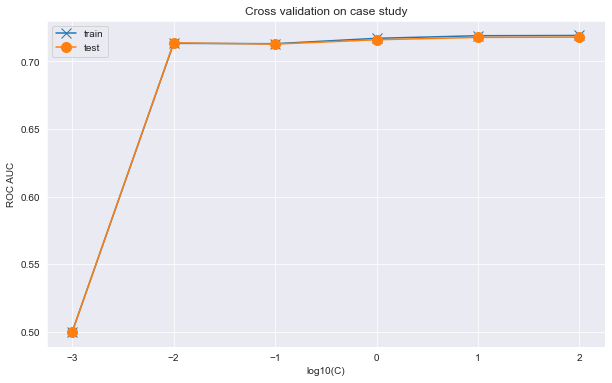

In [51]:
plt.figure(figsize=(10,6))
plt.plot(np.log10(C_vals),tra, marker='x', markersize=10,label='train')
plt.plot(np.log10(C_vals),tes, marker='o', markersize=10,label='test')

plt.title('Cross validation on case study')
plt.xlabel('log10(C)')
plt.ylabel('ROC AUC')
plt.legend()

_____________________________________________________
**Up next, create interaction features for the case study data using scikit-learn's `PolynomialFeatures`. You should use 2 as the degree of polynomial features. Confirm that the number of new features makes sense.**

In [52]:
poly= PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
df_poly=poly.fit_transform(df[feat])


In [53]:
df_poly.shape,y.shape

((26664, 153), (26664,))

_____________________________________________________
**Finally, repeat the cross-validation procedure and observe the model performance now.**

In [54]:
# Using the new features, make a 80:20 train/test split using a random seed of 24.**
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(df_poly, y, test_size=0.20, random_state=24)

In [55]:
    # Call the cross_val_C_search_pipe() function using the new training data.
# All other parameters should remain the same.
tra_p,tes_p=cross_val_C_search_pipe(k_folds,C_vals,pip,X_train_p,y_train_p)

# Note that this training may take a few minutes due to the larger number of features.


C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 100


C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 10


C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 1
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


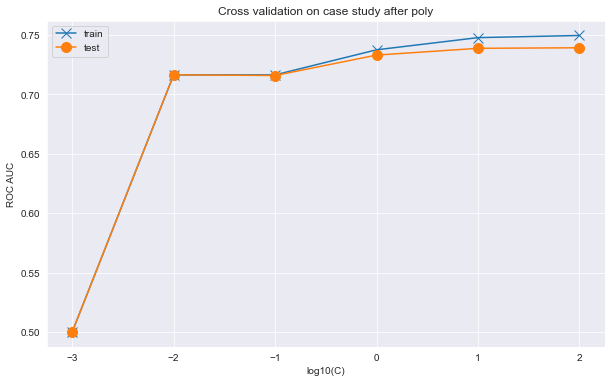

In [56]:
# Plot the average training and testing ROC AUC across folds, for each C value.
plt.figure(figsize=(10,6))
plt.plot(np.log10(C_vals),tra_p, marker='x', markersize=10,label='train')
plt.plot(np.log10(C_vals),tes_p, marker='o', markersize=10,label='test')

plt.title('Cross validation on case study after poly')
plt.xlabel('log10(C)')
plt.ylabel('ROC AUC')
plt.legend()

**Take a look at the above graph. Does the average cross-validation testing performance improve with the interaction features? Is regularization useful?**

In [ ]:
#yes it is usefull